# Asset Selling Problem Implementation

This notebook implements the asset selling problem as described in SDA book. The asset selling problem is a classic example of an sequential decision making problem where we need to decide when to sell an asset to maximize our returns.****


## Introduction

In this problem, we are holding a block of shares of stock, looking for an opportune time to sell. We assume we are a small player in the market, which means it doesn't matter how many shares we sell, so we'll assume we have just one share. If we sell at time t, we receive a price that varies according to some random process over time, although we don't believe prices are trending up or down. Once we sell the stock, the process stops.

We'll implement this problem using the sequential decision making framework and explore different policies for deciding when to sell the asset.

In [251]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown


# Set some plotting parameters
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 1. The Basic Model

Let's start by defining the basic model components as described in the text:

### 1.1 State Variables

Our process has two state variables:
- The "physical state" $R_t$, which captures whether or not we are still holding the asset
- The "informational state" $p_t$, which is the price of the stock

The physical state is defined as:

$$R_t = \begin{cases}
1 & \text{If we are holding the stock at time } t,\\
0 & \text{If we are no longer holding the stock at time } t.
\end{cases}$$

Our state variable is then $S_t = (R_t, p_t)$.

### 1.2 Decision Variables

The decision variable is whether to hold or sell the stock. We write this using:

$$x_t = \begin{cases}
1 & \text{If we sell the stock at time } t,\\
0 & \text{If we do not sell the stock at time } t.
\end{cases}$$

We can only sell the stock if we are holding it, so we have the constraint $x_t \leq R_t$.

### 1.3 Exogenous Information

The only random process in our basic model is the change in price $\hat{p}_{t+1} = p_{t+1} - p_t$. The price evolves according to:

$$p_{t+1} = p_t + \hat{p}_{t+1}$$

### 1.4 Transition Function

The transition function describes how the state evolves. For $R_t$, we have:

$$R_{t+1} = R_t - x_t$$

For $p_t$, we have:

$$p_{t+1} = p_t + \hat{p}_{t+1}$$

### 1.5 Objective Function

Our objective is to maximize the price at which we sell the stock. The contribution function is:

$$C(S_t, x_t) = p_t x_t$$

Since $x_t = 0$ until we sell our asset, at which point $x_t = 1$, this will happen just once over our horizon.

## 2. Implementing the Model


### 2.1 Modeling Uncertainty

In the text, we discuss modeling uncertainty in the price process. Our implementation supports two types of price models:

1. **Normal Model**: The price changes follow a normal distribution with mean 0 and variance $\sigma^2$.
2. **Time Series Model**: The price follows an AR(3) model where $p_{t+1} = \theta_0 p_t + \theta_1 p_{t-1} + \theta_2 p_{t-2} + \varepsilon_{t+1}$.

Let's compare these two models:

In [252]:
def generate_price_path(time_horizon, initial_price, drift, volatility):
    """
    Generates a single sample path of stock prices following a random walk.
    
    Parameters:
    -----------
    time_horizon : int
        Number of time periods to simulate (T)
    initial_price : float
        Starting price of the asset (p0)
    drift : float
        Mean of the price change distribution (μ)
    volatility : float
        Standard deviation of the price change distribution (σ)
        
    Returns:
    --------
    prices : numpy.ndarray
        Array of length time_horizon + 1 containing the price at each time step,
        where prices[0] is the initial price and prices[t] is the price at time t.
    """
    # Initialize price array with the initial price
    prices = np.zeros(time_horizon + 1)
    prices[0] = initial_price
    
    # Generate all price changes at once (vectorized approach)
    for t in range(time_horizon):
        prices[t+1] = prices[t] + np.random.normal(loc=drift, scale=volatility)
    
    return prices

Text(0.5, 0, 'Time')

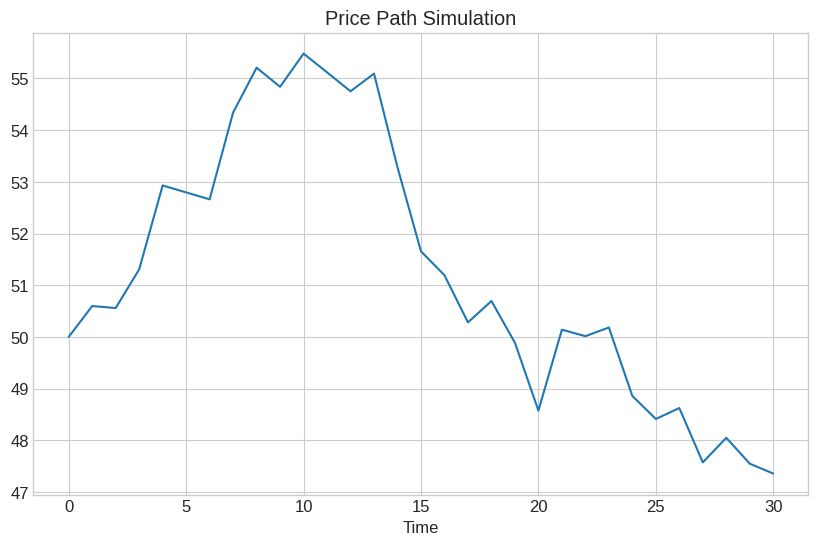

In [253]:
# --- 1. Model Parameters and Price Process Simulation ---

# Set a seed for reproducibility
np.random.seed(42)

# Simulation Parameters
T = 30       # Time horizon (number of periods to potentially hold)
p0 = 50.0    # Initial stock price
mu = 0.1     # Mean of price *change* (as per text example)
sigma = 1.0  # Standard deviation of price *change*


test_prices = generate_price_path(time_horizon = T, 
                                  initial_price = p0, 
                                  drift = mu, 
                                  volatility = sigma)

# Plot the price path
plt.figure(figsize=(10, 6))
plt.plot(test_prices, label='Price Path')
plt.title('Price Path Simulation')
plt.xlabel('Time')

Notice how the time series model shows more autocorrelation in the price changes, while the normal model exhibits more random walks.

## 3. Designing Policies

In the text, several policy types are introduced. Let's examine how these are implemented in the code.

### 3.2 High-Low Policy

This policy sells if the price is either too high or too low:

$$X^{high-low}(S_t|\theta_{high-low}) = \begin{cases}
1 & \text{If } p_t < \theta_{low} \text{ or } p_t > \theta_{high}\\
1 & \text{If } t = T \text{ and } R_t = 1\\
0 & \text{Otherwise}
\end{cases}$$

Let's test this policy:

Let's implement this policy and test it:

In [254]:
def policy_high_low(state, t, T, params):
    """
    Implements the high-low policy (Eq 2.14).
    Args:
        state (tuple): Current state (R_t, p_t) where R_t is 1 if holding, 0 otherwise.
        t (int): Current time step (decision period index 0 to T-1).
        T (int): Horizon length (total number of potential holding periods).
        params (dict): Dictionary containing policy parameters, e.g., {'theta_low': 45.0, 'theta_high': 55.0}.

    Returns:
        int: Decision x_t (1 to sell, 0 to hold).
    """
    R_t, p_t = state
    theta_low = params['theta_low']
    theta_high = params['theta_high']

    # Cannot sell if not holding
    if R_t == 0:
        return 0

    # Decision logic from Eq 2.14 (simplified - forced sale at T handled by simulation loop)
    # Sell if price is below lower threshold OR above upper threshold
    if p_t < theta_low or p_t > theta_high:
       decision = 1
    else:
       decision = 0

    # Ensure we only try to sell if holding (redundant given R_t check above, but safe)
    return decision * R_t

In [255]:
def simulate_one_path(policy_func, policy_params, T, p0, mu, sigma):
    """
    Simulates one sample path (omega) using a given policy.
    Calculates F_hat_pi(omega).

    Args:
        policy_func (function): The policy function to use (e.g., policy_sell_low).
        policy_params (dict): Parameters for the policy function.
        T (int): Horizon length (decisions from t=0 to T-1).
        p0 (float): Initial price.
        mu (float): Mean price change.
        sigma (float): Std dev price change.

    Returns:
        float: The final selling price obtained on this path (F_hat_pi(omega)).
               Returns 0 if somehow not sold (shouldn't happen with forced sale).
    """
    # Generate the full potential price path for this simulation run (omega)
    # prices array has length T+1 (indices 0 to T)
    prices = generate_price_path(T, p0, mu, sigma)
    #print(prices)
    # Initialize state S_0
    R_t = 1  # Start holding the asset (physical state)
    p_t = prices[0] # Initial price (information state)
    state = (R_t, p_t)

    selling_price = 0.0
    sell_time = -1

    # Simulate decision steps t = 0, 1, ..., T-1
    for t in range(T):
        p_t = prices[t]       # Price at the beginning of period t (relevant for decision x_t)
        state = (R_t, p_t)

        # Check if already sold in a previous period
        if R_t == 0:
            continue # Process stopped for this path, price already recorded

        # Get decision x_t from the policy based on state at time t
        # Note: T in policy function is horizon length, t is current step
        x_t = policy_func(state, t, T, policy_params)

        # Implement transition based on decision x_t
        if x_t == 1:
            # Sell action taken at time t based on price p_t
            selling_price = p_t  # Contribution C(S_t, x_t) = p_t * 1
            R_t = 0 # Update physical state R_{t+1} = R_t - x_t = 1 - 1 = 0
            sell_time = t
            # No need to continue simulation once sold
            break
        else:
            # Hold action taken (x_t = 0)
            R_t = R_t # R_{t+1} = R_t - 0 = R_t (remains 1)
            # Price transitions automatically via the pre-generated 'prices' array for p_{t+1}
            pass

    # Handle forced sale at the end (if not sold earlier)
    # If the loop finishes (meaning we held at T-1), we are forced to sell.
    # The relevant price is the final price p_T (index T in the array).
    if R_t == 1:
       selling_price = prices[T] # Sell at the final available price
       sell_time = T

    # This is F_hat_pi(omega) for this specific path
    return selling_price

In [256]:
# Set a seed for reproducibility
np.random.seed(42)

# Define parameters
T = 30           # Time horizon
p0 = 50.0        # Initial price
mu = 0.1       # Mean price change
sigma = 1.0      # Standard deviation of price change

# Define high-low policy parameters
policy_params = {'theta_low': 45.0, 'theta_high': 55.0}

# Run the simulation
selling_price = simulate_one_path(
    policy_func=policy_high_low, 
    policy_params=policy_params, 
    T=T, p0=p0, mu=mu, sigma=sigma
)

# Print the result
print(f"Using high-low policy with θ_low={policy_params['theta_low']} and θ_high={policy_params['theta_high']}")
print(f"Selling price: {selling_price:.2f}")


Using high-low policy with θ_low=45.0 and θ_high=55.0
Selling price: 55.21


In [257]:
# --- 4. Policy Evaluation ---

def evaluate_policy(policy_func, policy_params, N, T, p0, mu, sigma):
    """
    Evaluates a policy by simulating N sample paths and averaging results.
    Calculates F_pi (average performance) and its standard error.

    Args:
        policy_func (function): The policy function.
        policy_params (dict): Parameters for the policy function.
        N (int): Number of sample paths (simulations) to run.
        T, p0, mu, sigma: Simulation parameters.

    Returns:
        tuple: (average_selling_price, std_dev_selling_price, std_error_mean)
               average_selling_price is F_pi estimate.
    """
    results = []
    for _ in range(N):
        selling_price = simulate_one_path(policy_func, policy_params, T, p0, mu, sigma)
        results.append(selling_price)

    results = np.array(results)
    average_selling_price = np.mean(results) # F_pi estimate (Eq 2.9)
    # Use ddof=1 for sample standard deviation (unbiased estimate of population variance)
    std_dev_selling_price = np.std(results, ddof=1) # Sample std dev (sqrt of variance in text)
    std_error_mean = std_dev_selling_price / np.sqrt(N) # Std dev of the *average* F_pi (sqrt of (sigma_bar_pi)^2)

    return average_selling_price, std_dev_selling_price, std_error_mean

In [258]:
# Evaluate high-low policy
policy_params = {'theta_low': 45.0, 'theta_high': 55.0}
evaluate_policy(policy_func=policy_high_low, 
                policy_params=policy_params, 
                N=1000, T=T, p0=p0, mu=mu, 
                sigma=sigma)

(52.0922485266661, 4.316109805194618, 0.13648737615800635)

7. Policy Comparison: Balanced Band, Ride the Trend, and Aggressive Take-Profit
# 
# In this section, we'll implement and compare three different selling policies:
# 
# 1. **Balanced Band (θ_low=45, θ_high=55)**: A symmetric policy that provides balanced protection and profit potential around p0=50.
# 2. **Ride the Trend (θ_low=40, θ_high=60)**: A wider band with a higher target, designed to capture upward drift.
# 3. **Aggressive Take-Profit (θ_low=10, θ_high=55)**: |Focuses solely on the upper threshold, effectively ignoring downside protection.
# 
# We'll evaluate these policies and visualize their performance.

### 7. Policy Comparison: Balanced Band, Ride the Trend, and Aggressive Take-Profit


In this section, we'll implement and compare three different selling policies:

1. **Balanced Band (θ_low=45, θ_high=55)**: A symmetric policy that provides balanced protection and profit potential around p0=50.
2. **Ride the Trend (θ_low=40, θ_high=60)**: A wider band with a higher target, designed to capture upward drift.
3. **Aggressive Take-Profit (θ_low=10, θ_high=55)**: Focuses solely on the upper threshold, effectively ignoring downside protection. 

We'll evaluate these policies and visualize their performance.

In [259]:
def run_policy_comparison(N=100000, T=30, p0=50.0, mu=0.1, sigma=2.0):
    """
    Runs a comparison of the three policies and returns their performance metrics.
    
    Args:
        N: Number of simulation paths
        T: Time horizon
        p0: Initial price
        mu: Mean price change (drift)
        sigma: Volatility of price change
        
    Returns:
        Dictionary containing the performance metrics for each policy
    """
    # Define the three policies
    balanced_band_params = {'theta_low': 48.0, 'theta_high': 52.0}
    ride_the_trend_params = {'theta_low': 45.0, 'theta_high': 55.0}
    aggressive_take_profit_params = {'theta_low': 40.0, 'theta_high': 60.0}
    
    # Set a seed for reproducibility
    #np.random.seed(42)
    
    # Evaluate each policy
    print("Evaluating Balanced Band policy...")
    balanced_result = evaluate_policy(
        policy_func=policy_high_low,
        policy_params=balanced_band_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    print("Evaluating Ride the Trend policy...")
    ride_trend_result = evaluate_policy(
        policy_func=policy_high_low, 
        policy_params=ride_the_trend_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    print("Evaluating Aggressive Take-Profit policy...")
    aggressive_result = evaluate_policy(
        policy_func=policy_high_low,
        policy_params=aggressive_take_profit_params,
        N=N, T=T, p0=p0, mu=mu, sigma=sigma
    )
    
    # Organize results
    results = {
        "Balanced Band": {
            "params": balanced_band_params,
            "avg_price": balanced_result[0],
            "std_dev": balanced_result[1],
            "std_error": balanced_result[2]
        },
        "Ride the Trend": {
            "params": ride_the_trend_params,
            "avg_price": ride_trend_result[0],
            "std_dev": ride_trend_result[1],
            "std_error": ride_trend_result[2]
        },
        "Aggressive Take-Profit": {
            "params": aggressive_take_profit_params,
            "avg_price": aggressive_result[0],
            "std_dev": aggressive_result[1],
            "std_error": aggressive_result[2]
        }
    }
    
    return results

# Run the policy comparison
policy_results = run_policy_comparison(N=100000)

# Display the results in a table
import pandas as pd

results_df = pd.DataFrame({
    'Policy': ['Balanced Band', 'Ride the Trend', 'Aggressive Take-Profit'],
    'θ_low': [policy_results[p]['params']['theta_low'] for p in policy_results],
    'θ_high': [policy_results[p]['params']['theta_high'] for p in policy_results],
    'Avg. Selling Price': [policy_results[p]['avg_price'] for p in policy_results],
    'Std Dev': [policy_results[p]['std_dev'] for p in policy_results],
    'Std Error': [policy_results[p]['std_error'] for p in policy_results]
})

display(results_df)

Evaluating Balanced Band policy...
Evaluating Ride the Trend policy...
Evaluating Aggressive Take-Profit policy...


,Policy,θ_low,θ_high,Avg. Selling Price,Std Dev,Std Error
0,Balanced Band,48.0,52.0,50.267501,3.332629,0.010539
1,Ride the Trend,45.0,55.0,50.969789,6.112930,0.019331
2,Aggressive Take-Profit,40.0,60.0,52.175752,9.094974,0.028761


### 3.3 Tracking Policy

The tracking policy sells if the price rises above a tracking signal:

$$\bar{p}_t = (1 - \alpha)\bar{p}_{t-1} + \alpha\hat{p}_t$$

$$X^{track}(S_t|\theta_{track}) = \begin{cases}
1 & \text{If } p_t \geq \bar{p}_t + \theta_{track}\\
1 & \text{If } t = T \text{ and } R_t = 1\\
0 & \text{Otherwise}
\end{cases}$$

Let's test this policy with different alpha values:

## 4. Policy Evaluation

In the text, the method for evaluating policies is described using simulation. Let's compare several policies using the same sample paths:

Let's also examine the statistical significance of the differences between policies as described in the text. We'll compute confidence intervals for the differences between pairs of policies:

## 5. Extensions: Time Series Price Process

As described in the text, we can extend our model to include a more realistic price process that captures autocorrelation over time:

$$p_{t+1} = \theta_0 p_t + \theta_1 p_{t-1} + \theta_2 p_{t-2} + \varepsilon_{t+1}$$

This requires us to expand our state to include price history:

$$S_t = (R_t, p_t, p_{t-1}, p_{t-2})$$

Let's compare the performance of our policies on the time series model:

## 6. Conclusion

In this notebook, we've implemented and analyzed the asset selling problem as described in the text. We've explored different policies for deciding when to sell an asset, evaluated their performance through simulation, and examined the impact of different price models.

Key takeaways:

1. The asset selling problem can be formulated as a sequential decision making problem with clear state variables, decision variables, and transition functions.

2. We can implement various policies, from simple ones like "sell immediately" to more sophisticated ones like tracking and optimal stopping.

3. The choice of price model (normal vs. time series) can significantly impact the performance of different policies.

4. Simulation is a powerful tool for evaluating and comparing policies, allowing us to estimate expected performance and compute confidence intervals.